In [1]:
from goofit import *

In [2]:
from matplotlib import pyplot as plt

In [3]:
from scipy.special import binom
from scipy import integrate

In [4]:
import numpy as np

In [5]:
import random

In [52]:
from cycler import cycler

In [6]:
def bern_func(x,i=0,n=2):
    
    r = binom(n,i)*(x**i)*((1-x)**(n-i))
    #val = val + r
    return r

In [7]:
def bern_func_gen(x,lowX,uppX,i=0,n=2):
    xNorm = (x-lowX)/(uppX - lowX)
    r = bern_func(xNorm,i=i,n=n)
    return r

### Bernstein Function

In [20]:
xmin = np.random.uniform(-20.0,20.0)
xmax = np.random.uniform(xmin,40.0)

deg = 7

In [25]:
xvar = Observable("x",xmin,xmax)

Bernstein p.d.f. analytical components for a 7 order polynomial compared to Goofit p.d.f.

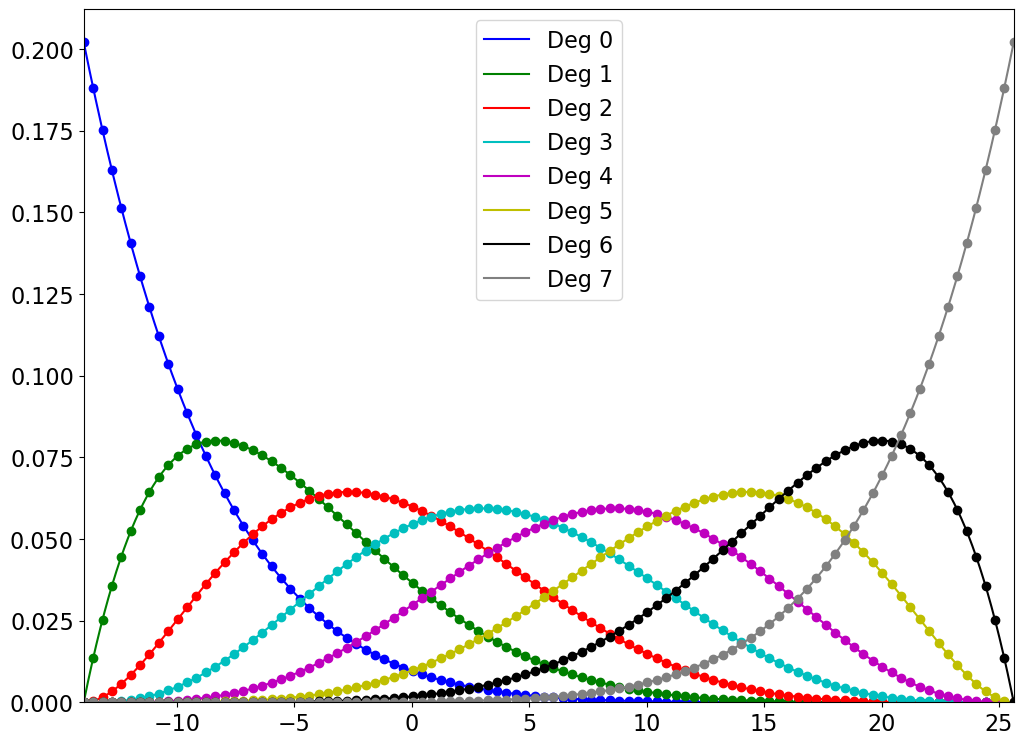

In [78]:
plt.figure(figsize=(12,9))

for i,c in zip(range(0,deg+1),['b','g','r','c','m','y','k','grey']):
    
    y_integral = integrate.romberg(bern_func_gen, xmin, xmax, args=(xmin,xmax,i,deg), show=False)
    plt.plot(x_points,bern_func_gen(x_points,xmin,xmax,i=i,n=deg)/y_integral,"o",color=c)
    
    aS = []
    for j in range(0,deg+1):
    
        if j==i:
            aS.append(Variable("a%d"%j,1.0))
        else:
            aS.append(Variable("a%d"%j,0.0))
            
    bern = BernsteinPdf("bern", xvar,aS,0)
    xvar.numbins= 20000
    grid = bern.makeGrid()
    bern.setData(grid)

    pdf = bern.evaluatePdf(xvar)  
    xvals = grid.to_matrix().flatten()

    plt.plot(xvals, pdf[1], label='Deg %d'%i,color=c)
    
ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.legend(fontsize=16)

In [98]:
aS_gen = []

for j in range(0,deg+1):
    a_val = random.uniform(0.0,1.0)
    aS_gen.append(a_val)
    
def gen_bern(x,lowX,uppX):
    r = 0
    xNorm = (x-lowX)/(uppX - lowX)
    for j in range(0,deg+1):
        r = r + aS_gen[j] * bern_func_gen(x,xmin,xmax,i=j,n=deg)
    return r

In [99]:
y_integral = integrate.romberg(gen_bern, xmin, xmax, args=(xmin,xmax), show=False)

y_points = gen_bern(x_points,xmin,xmax)
y_max = y_points.max()
y_points = y_points/y_integral


In [100]:
binw = (xmax - xmin)/100.0

In [117]:
dats = []

n_events = int(5e7)

for i in range(n_events):
    this_x = np.random.uniform(xmin,xmax)
    this_y = gen_bern(this_x,xmin,xmax)
    this_roll = np.random.uniform(0.0,y_max*1.01)
    if this_y > this_roll:
        dats.append(this_x)

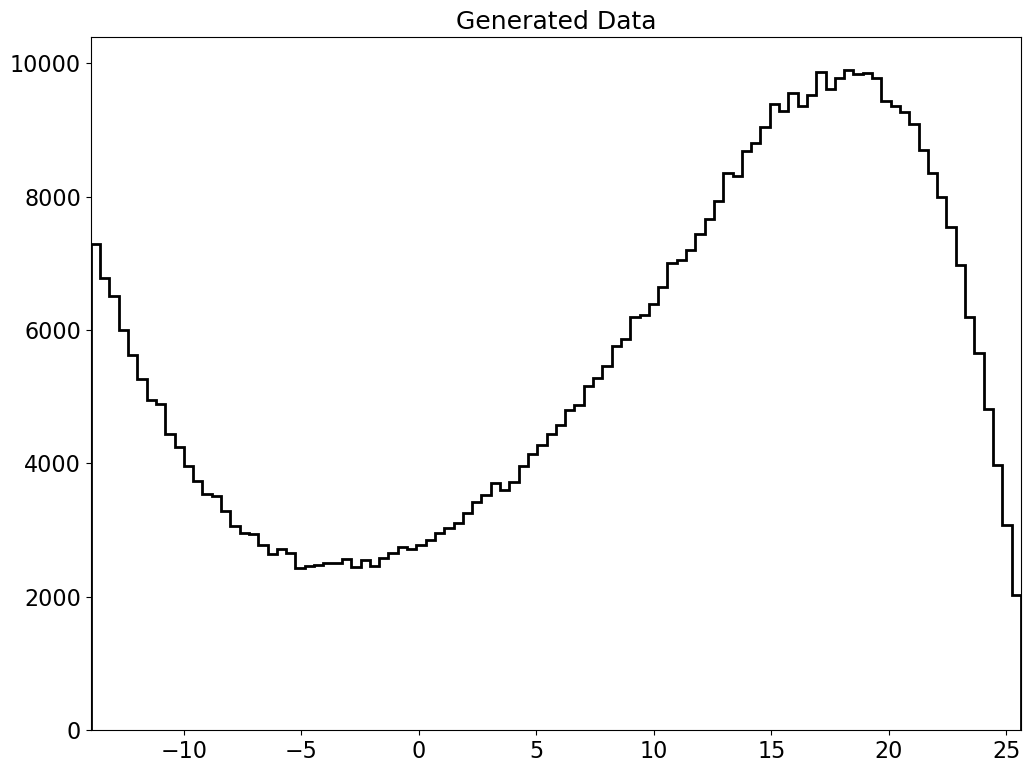

In [106]:
#plt.plot(x_points,y_points*n_events*binw/(y_integral),color="blue",lw=2);
plt.hist(dats,histtype="step",color="black",lw=2,bins=100);

ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title("Generated Data",fontsize=18);

In [108]:
aS = []
for j in range(deg+1):
    aS.append(Variable("a%d"%j,0.7,0.0,1.0))
bern = BernsteinPdf("bern", xvar,aS,0)

In [109]:
data = UnbinnedDataSet(xvar);
data.from_numpy([dats],filter=True)

In [110]:
bern.setData(data)
bern.fit()

MnSeedGenerator: for initial parameters FCN = 4065515.431082
MnSeedGenerator: Initial state:   - FCN =   4065515.431082 Edm =     -59020.5 NCalls =     33
MnSeedGenerator: Negative G2 found - new state:   - FCN =   3982018.105247 Edm =      69962.6 NCalls =     90
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   3982018.105247 Edm =      69962.6 NCalls =     90
VariableMetric: Iteration #   0 - FCN =   3982018.105247 Edm =      69962.6 NCalls =     90
VariableMetric: Iteration #   1 - FCN =   3961048.494059 Edm =      23621.5 NCalls =    115
VariableMetric: Iteration #   2 - FCN =   3955811.626132 Edm =      19817.7 NCalls =    139
VariableMetric: Iteration #   3 - FCN =   3951973.549357 Edm =         1975 NCalls =    161
VariableMetric: Iteration #   4 - FCN =   3950266.798076 Edm =      315.666 NCalls =    186
VariableMetric: Iteration #   5 - FCN =   3949880.159378 Edm =      34.8433 NCalls =    205
VariableMetric: Iteration #   6 - FCN

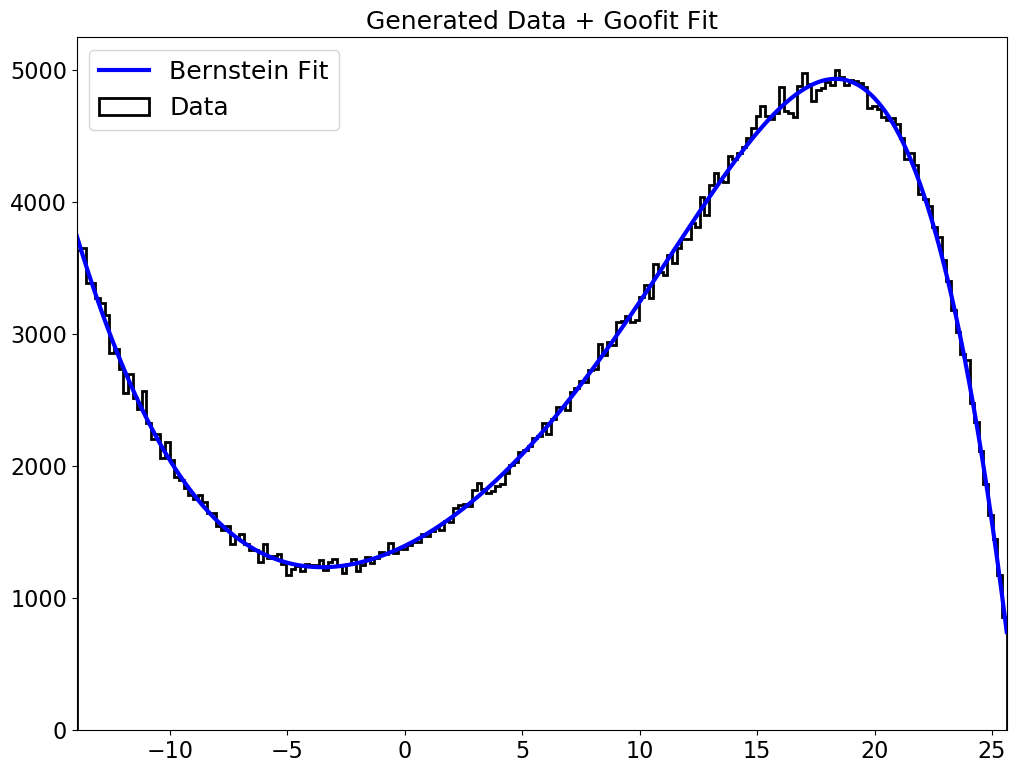

In [112]:
numbins = 200
binw = (xmax-xmin)/numbins

plt.hist(dats, bins=numbins, label='Data', density=False,histtype="step",lw="2",color="black")

grid = bern.makeGrid()
bern.setData(grid)

main = np.array(bern.getCompProbsAtDataPoints()[0])
main = main*float(len(dats))*binw

xvals = grid.to_matrix().flatten()

plt.plot(xvals, main, label='Bernstein Fit',lw=3,color="blue")

plt.legend(fontsize=18)

ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.title("Generated Data + Goofit Fit",fontsize=18);

In [116]:
for a,g in zip(aS,aS_gen):
    print(" %.3e  -  %.3e "%(a.value,g))

 4.267e-01  -  3.913e-01 
 4.996e-02  -  4.622e-02 
 3.502e-02  -  3.227e-02 
 2.574e-01  -  2.526e-01 
 9.354e-02  -  4.157e-02 
 5.710e-01  -  5.667e-01 
 9.998e-01  -  9.056e-01 
 8.466e-02  -  7.826e-02 
